In [1]:
!pip install --upgrade pip setuptools wheel
!pip install cartopy xarray netCDF4 matplotlib numpy
!pip install shapely pyproj scipy

In [2]:
import os
import glob
import numpy as np
import xarray as xr
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import matplotlib.colors as mcolors

In [3]:
drive.mount('/content/drive')
input_dir = "/content/drive/MyDrive/FILDA_DATA_MULTI/"
filenames = sorted(os.listdir(input_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ds = xr.open_dataset(input_dir + filenames[0])
ds

<xarray.Dataset> Size: 208MB
Dimensions:           (nFire: 1787, nRow: 6496, nCol: 6400, nRow_QA: 6496,
                       nCol_QA: 6400)
Coordinates:
    FP_Latitude       (nFire) float32 7kB ...
    FP_Longitude      (nFire) float32 7kB ...
Dimensions without coordinates: nFire, nRow, nCol, nRow_QA, nCol_QA
Data variables: (12/77)
    crs               int32 4B ...
    DNB_observations  (nFire) float32 7kB ...
    FP_MCE            (nFire) float32 7kB ...
    FP_VEF            (nFire) float32 7kB ...
    FP_Status         (nFire) int8 2kB ...
    FP_Num_Fire       (nFire) int8 2kB ...
    ...                ...
    FP_Land_Type      (nFire) int8 2kB ...
    FP_Gas_Flaring    (nFire) int8 2kB ...
    FP_Peatland       (nFire) int8 2kB ...
    FP_Peatfrac       (nFire) float32 7kB ...
    FP_AdjWater       (nFire) int8 2kB ...
    FP_AdjCloud       (nFire) int8 2kB ...
Attributes: (12/44)
    history:                           Created Sat Nov  9 01:21:13 2024 /tis/...
    source:                            FILDA detecion on VNP
    EastBoundingCoordinate:            -98.885
    PGE_EndTime:                       2018-11-09 09:54:00
    LongName:                          VIIRS/NPP FILDA-2 Fire Modified Combus...
    ShortName:                         VNP47IMG
    ...                                ...
    LocalGranuleID:                    VNP47IMG.A2018313.0948.002.20243140617...
    GRingPointLatitude:                [21.2021 25.7581 46.6752 40.9043]
    Conventions:                       CF-1.6
    creator_url:                       http://ladsweb.nascom.nasa.gov
    AlgorithmVersion:                  NPP_PR47 1.0.0
    StartTime:                         2018-11-09 09:48:00

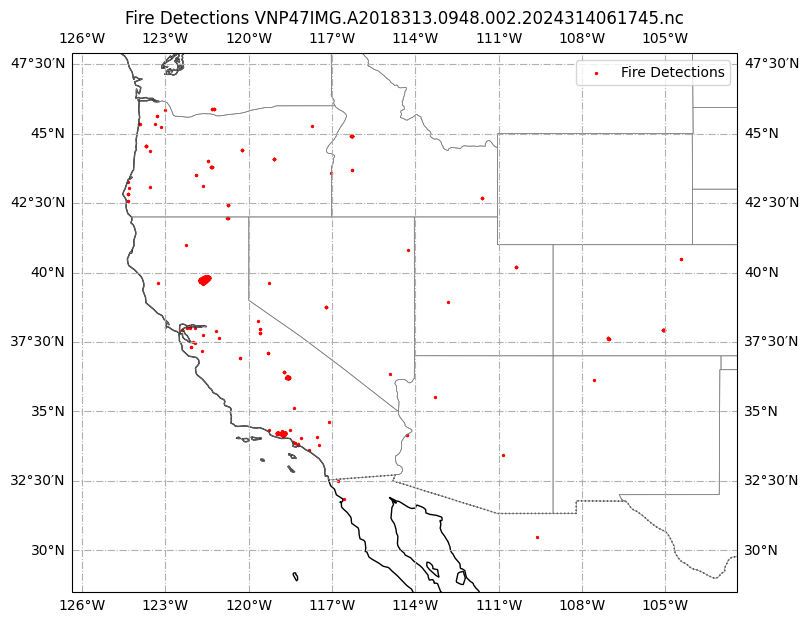

In [5]:
# Add padding to the plot extent for better visualization (in degrees)
pad_lat = 2  # Degrees to pad on the north/south (latitude) edges
pad_lon = 2  # Degrees to pad on the east/west (longitude) edges

# Find the min and max latitude and longitude from the fire detection dataset
min_lat, max_lat = np.nanmin(ds['FP_Latitude'].values), np.nanmax(ds['FP_Latitude'].values)
min_lon, max_lon = np.nanmin(ds['FP_Longitude'].values), np.nanmax(ds['FP_Longitude'].values)

# Define the map extent with added padding: [west, east, south, north]
extent = [min_lon - pad_lon, max_lon + pad_lon, min_lat - pad_lat, max_lat + pad_lat]

# Create the plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())  # Zoom to region of detections plus padding

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
ax.gridlines(ls='-.', draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot the fire detection locations as red points
ax.scatter(ds['FP_Longitude'], ds['FP_Latitude'],
           color='red', s=2, transform=ccrs.PlateCarree(), label='Fire Detections')

plt.legend(loc='upper right')
plt.title(f"Fire Detections {filenames[0]}")  # Title includes first filename (customize as needed)
plt.show()

/tmp/ipython-input-6-2212484408.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


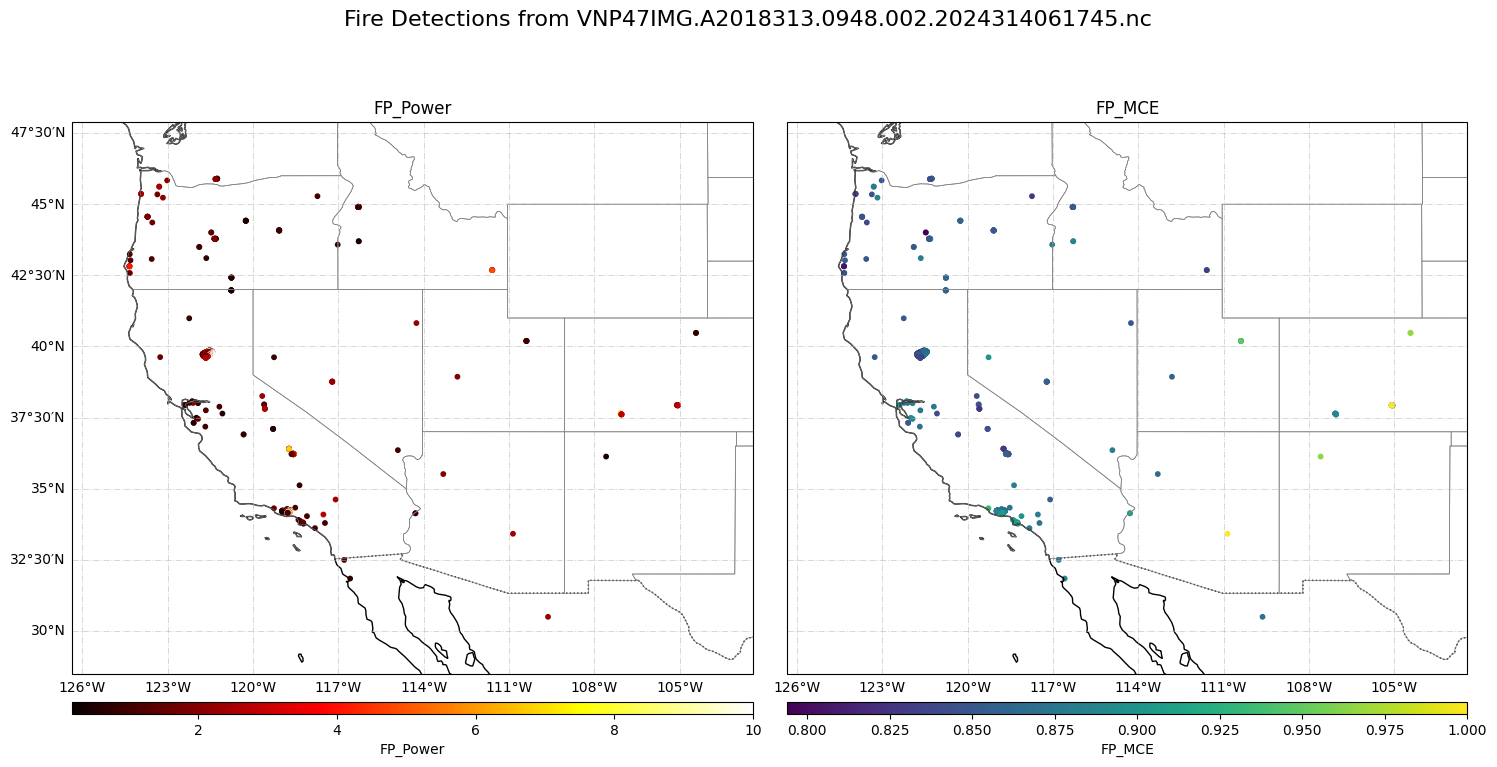

In [6]:
def add_horizontal_cbar(fig, ax, ratio=0.06, y_off=-0.08):
    """
    Add a horizontal colorbar axis under ax.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
    ratio : float
        Height of the colorbar as a ratio of the axis width.
    y_off : float
        Vertical offset from the bottom of the axis (in figure fraction).
    Returns
    -------
    cax : axes
        New axes for the colorbar.
    """
    pos = ax.get_position()
    width = pos.width
    cbar_height = width * ratio
    cax = fig.add_axes([pos.x0, pos.y0 + y_off, width, cbar_height])
    return cax


def multiFigure(nRow, nCol, proj=None, figsize=(14,7)):
    """Simple grid for panel Cartopy maps."""
    import matplotlib.gridspec as gridspec
    if proj is None:
        proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nRow, nCol, figure=fig, wspace=0.05)
    axes = []
    for i in range(nRow):
        for j in range(nCol):
            ax = fig.add_subplot(gs[i, j], projection=proj)
            axes.append(ax)
    return fig, axes, proj


# Remove nan or invalid entries (optional for clarity)
mask = np.isfinite(ds['FP_Latitude']) & np.isfinite(ds['FP_Longitude']) & np.isfinite(ds['FP_Power']) & np.isfinite(ds['FP_MCE'])

lats = ds['FP_Latitude'].values[mask]
lons = ds['FP_Longitude'].values[mask]
powers = ds['FP_Power'].values[mask]
mces = ds['FP_MCE'].values[mask]

# Set extent based on valid data with padding
pad_lat, pad_lon = 2, 2
min_lat, max_lat = np.nanmin(lats), np.nanmax(lats)
min_lon, max_lon = np.nanmin(lons), np.nanmax(lons)
extent = [min_lon - pad_lon, max_lon + pad_lon, min_lat - pad_lat, max_lat + pad_lat]

fig, axes, proj = multiFigure(1, 2, figsize=(18,8), proj=ccrs.PlateCarree())

# Panel 1: FP_Power
im1 = axes[0].scatter(lons, lats, c=powers, cmap='hot', s=10, transform=ccrs.PlateCarree(), vmax = 10)
axes[0].set_extent(extent, crs=ccrs.PlateCarree())
axes[0].set_title('FP_Power')
axes[0].coastlines(); axes[0].add_feature(cfeature.BORDERS, linestyle=':'); axes[0].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Panel 2: FP_MCE
im2 = axes[1].scatter(lons, lats, c=mces, cmap='viridis', s=10, transform=ccrs.PlateCarree())
axes[1].set_extent(extent, crs=ccrs.PlateCarree())
axes[1].set_title('FP_MCE')
axes[1].coastlines(); axes[1].add_feature(cfeature.BORDERS, linestyle=':'); axes[1].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Add well-aligned horizontal colorbars under each panel
cax1 = add_horizontal_cbar(fig, axes[0], ratio=0.04, y_off=-0.05)
cb1 = plt.colorbar(im1, cax=cax1, orientation='horizontal', label='FP_Power')

cax2 = add_horizontal_cbar(fig, axes[1], ratio=0.04, y_off=-0.05)
cb2 = plt.colorbar(im2, cax=cax2, orientation='horizontal', label='FP_MCE')


# add the lat/lon for each panel
for i, ax in enumerate(axes):
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linestyle='-.', linewidth=0.7, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.left_labels = False
    if i == 0:
        gl.bottom_labels = True

plt.suptitle(f"Fire Detections from {filenames[0]}", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

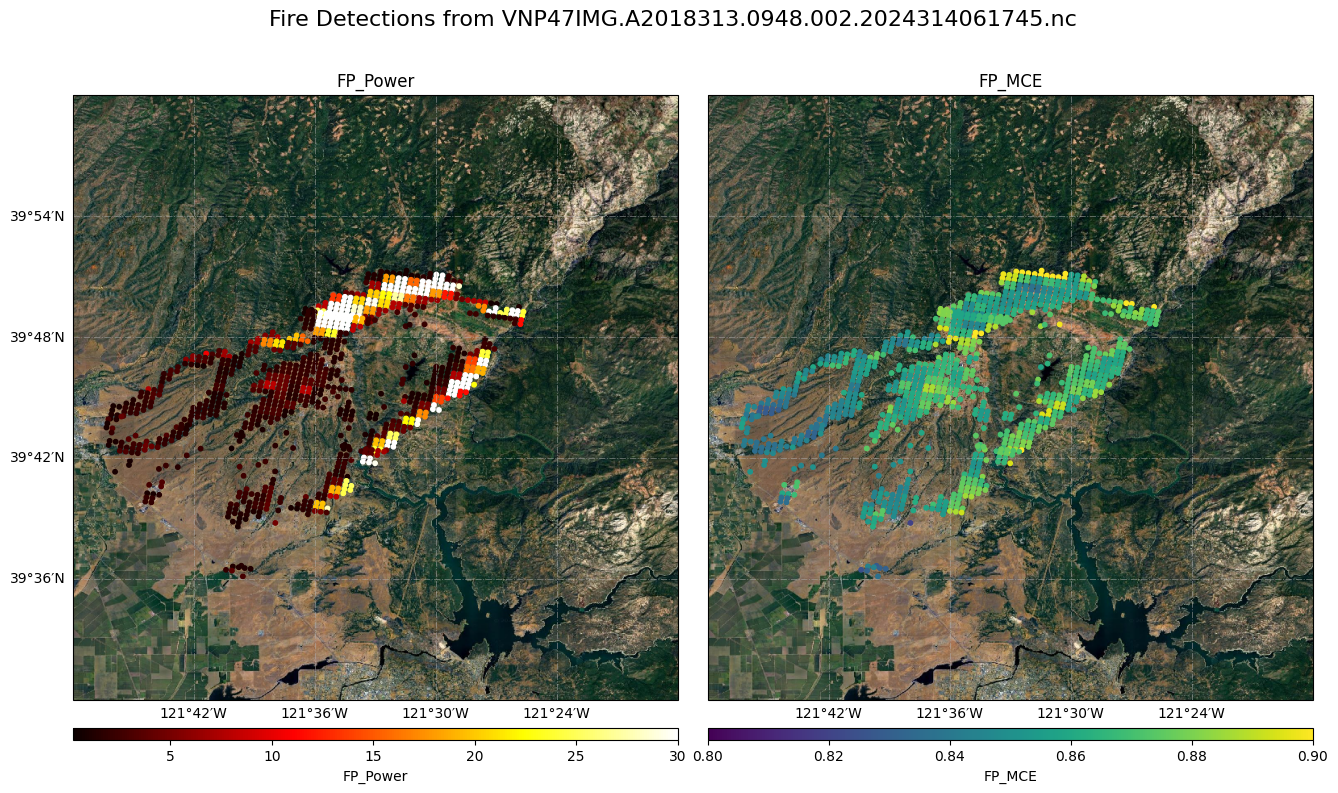

In [7]:
import cartopy.io.img_tiles as cimgt

# Remove nan or invalid entries (optional for clarity)
mask = np.isfinite(ds['FP_Latitude']) & np.isfinite(ds['FP_Longitude']) & np.isfinite(ds['FP_Power']) & np.isfinite(ds['FP_MCE'])

lats = ds['FP_Latitude'].values[mask]
lons = ds['FP_Longitude'].values[mask]
powers = ds['FP_Power'].values[mask]
mces = ds['FP_MCE'].values[mask]

# Set extent
extent = (-121.8, -121.3, 39.5, 40)  # (west, east, south, north)

# Use Stamen Terrain or Toner; for Google-like imagery, use Stamen 'terrain-background' or 'satellite'
# tiler = cimgt.Stamen('terrain-background')  # Or use 'terrain', 'toner', etc.
tiler = cimgt.GoogleTiles(style='satellite')  # Google imagery, may require extra API/authentication and may not work in all environments
# For best zoom, select appropriate zoom level for your domain size (e.g., 10-14 for local fires)
zoom = 12

fig, axes, proj = multiFigure(1, 2, figsize=(16,8), proj=ccrs.PlateCarree())

for i, ax in enumerate(axes):
    # Set background imagery
    ax.add_image(tiler, zoom)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # Overlay borders, states, etc. as before
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    # Overlay fire detections
    if i == 0:
        im = ax.scatter(lons, lats, c=powers, cmap='hot', s=10, transform=ccrs.PlateCarree(), vmax=30)
    else:
        im = ax.scatter(lons, lats, c=mces, cmap='viridis', s=10, transform=ccrs.PlateCarree(), vmin=0.8, vmax=0.90)
    # Gridlines and lat/lon labels
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linestyle='-.', linewidth=0.7, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.left_labels = False
    if i == 0:
        gl.bottom_labels = True

    # Colorbars
    cax = add_horizontal_cbar(fig, ax, ratio=0.04, y_off=-0.05)
    plt.colorbar(im, cax=cax, orientation='horizontal', label=['FP_Power', 'FP_MCE'][i])

axes[0].set_title('FP_Power')
axes[1].set_title('FP_MCE')
plt.suptitle(f"Fire Detections from {filenames[0]}", fontsize=16)
plt.show()


## **Then, let's remove the bowtie affected pixel**

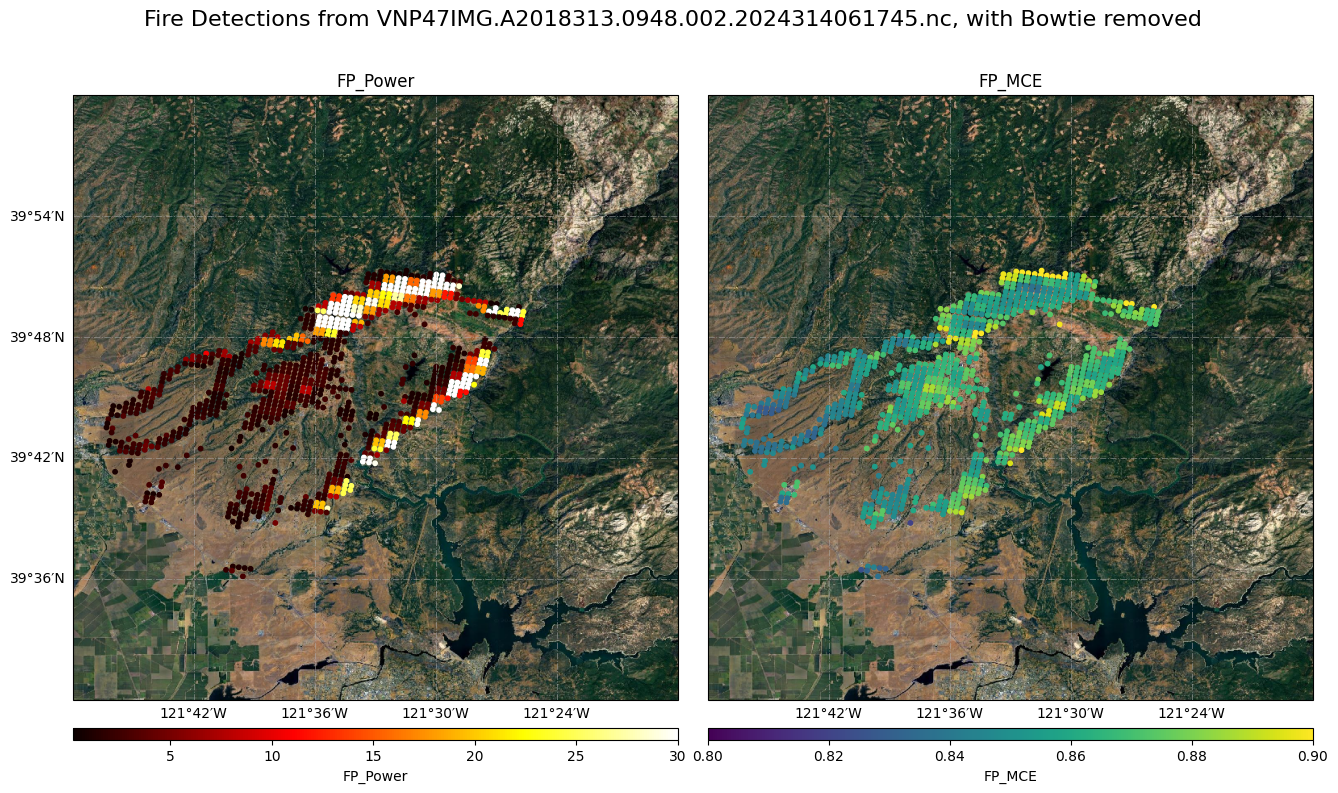

In [8]:
import cartopy.io.img_tiles as cimgt

# Remove nan or invalid entries (optional for clarity)
mask = np.isfinite(ds['FP_Latitude']) & np.isfinite(ds['FP_Longitude']) & np.isfinite(ds['FP_Power']) & np.isfinite(ds['FP_MCE']) & (ds['FP_Bowtie']<0.05)

lats = ds['FP_Latitude'].values[mask]
lons = ds['FP_Longitude'].values[mask]
powers = ds['FP_Power'].values[mask]
mces = ds['FP_MCE'].values[mask]

# Set extent
extent = (-121.8, -121.3, 39.5, 40)  # (west, east, south, north)

# Use Stamen Terrain or Toner; for Google-like imagery, use Stamen 'terrain-background' or 'satellite'
# tiler = cimgt.Stamen('terrain-background')  # Or use 'terrain', 'toner', etc.
tiler = cimgt.GoogleTiles(style='satellite')  # Google imagery, may require extra API/authentication and may not work in all environments
# For best zoom, select appropriate zoom level for your domain size (e.g., 10-14 for local fires)
zoom = 12

fig, axes, proj = multiFigure(1, 2, figsize=(16,8), proj=ccrs.PlateCarree())

for i, ax in enumerate(axes):
    # Set background imagery
    ax.add_image(tiler, zoom)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # Overlay borders, states, etc. as before
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    # Overlay fire detections
    if i == 0:
        im = ax.scatter(lons, lats, c=powers, cmap='hot', s=10, transform=ccrs.PlateCarree(), vmax=30)
    else:
        im = ax.scatter(lons, lats, c=mces, cmap='viridis', s=10, transform=ccrs.PlateCarree(), vmin=0.8, vmax=0.90)
    # Gridlines and lat/lon labels
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linestyle='-.', linewidth=0.7, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.left_labels = False
    if i == 0:
        gl.bottom_labels = True

    # Colorbars
    cax = add_horizontal_cbar(fig, ax, ratio=0.04, y_off=-0.05)
    plt.colorbar(im, cax=cax, orientation='horizontal', label=['FP_Power', 'FP_MCE'][i])

axes[0].set_title('FP_Power')
axes[1].set_title('FP_MCE')
plt.suptitle(f"Fire Detections from {filenames[0]}, with Bowtie removed", fontsize=16)
plt.show()


## **Fire progression**

In [9]:
# Utility: Parse observation time from filename (customize as needed)
def extract_obs_day(filename):
    # Parse 'Ayyyydoy' (e.g., 'A2018313') to mm-dd
    try:
        field = filename.split('.')[1]  # Should be Ayyyydoy
        if field.startswith('A') and len(field) == 8:

            year = int(field[1:5])
            jday = int(field[5:8])

            date = datetime(year, 1, 1) + timedelta(days=jday-1)

            return date.strftime('%m-%d')

    except Exception:
        pass
    return "unknown"

# Aggregate all detections and their day labels
all_lats, all_lons, day_labels = [], [], []
for fname in filenames:
    fpath = os.path.join(input_dir, fname)
    try:
        with xr.open_dataset(fpath) as ds:
            mask = (
                np.isfinite(ds['FP_Latitude']) &
                np.isfinite(ds['FP_Longitude']) &
                np.isfinite(ds['FP_Power']) &
                np.isfinite(ds['FP_MCE']) &
                (ds['FP_Bowtie']<0.05)
            )
            lats = ds['FP_Latitude'].values[mask]
            lons = ds['FP_Longitude'].values[mask]
            obs_day = extract_obs_day(fname)
            all_lats.extend(lats)
            all_lons.extend(lons)
            day_labels.extend([obs_day] * len(lats))
    except Exception as e:
        print(f"Failed to process {fname}: {e}")

all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
day_labels = np.array(day_labels)

# Get unique days, sorted as they appear
days_unique = []
for d in day_labels:
    if d not in days_unique:
        days_unique.append(d)

day_indices = np.array([days_unique.index(d) for d in day_labels])
Ndays = len(days_unique)


Text(0.5, 1.0, 'Fire Progression (color = day)')

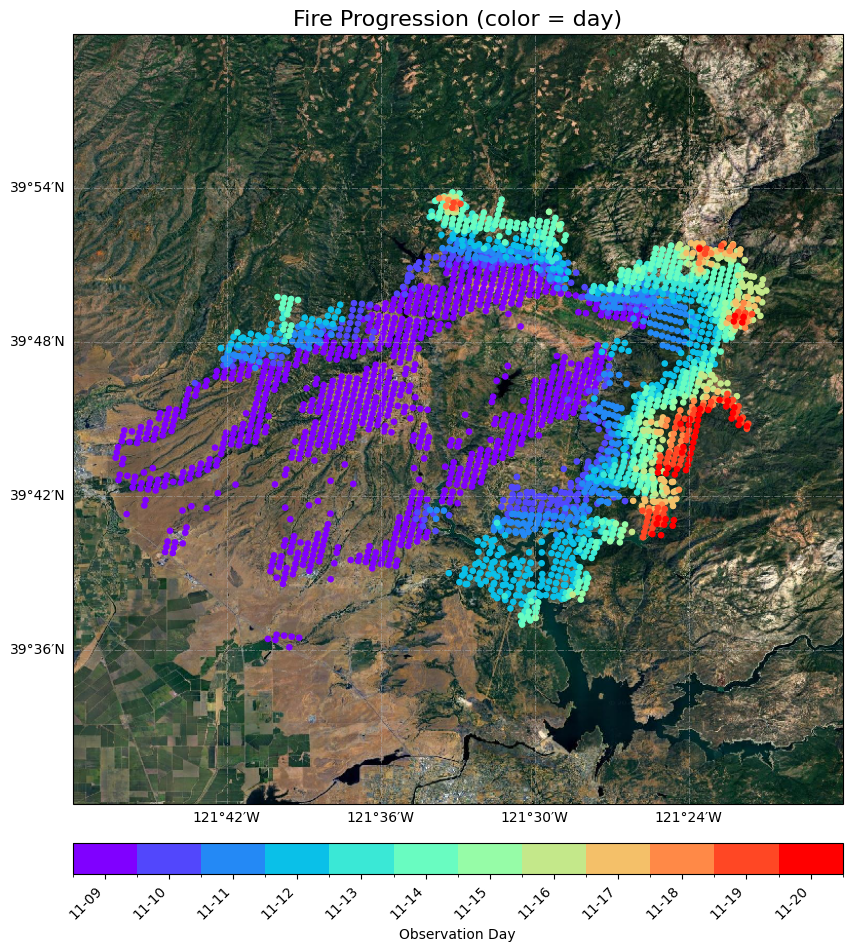

In [10]:
# Create a 1x1 panel map using a flexible utility that supports Cartopy projections
fig, axes, proj = multiFigure(1, 1, figsize=(10, 10), proj=ccrs.PlateCarree())
ax = axes[0]

# Set the map extent based on data and add standard cartographic features
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')  # Adds detailed coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')  # National borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)  # US state boundaries

# Add gridlines with degree-minute-second formatting and no overlap on top/right
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linestyle='-.', linewidth=0.7, alpha=0.5)
gl.top_labels = False  # Only show latitude labels on left
gl.right_labels = False  # Only show longitude labels on bottom

# Add a high-resolution Google satellite imagery background for geographic context
tiler = cimgt.GoogleTiles(style='satellite')  # May require API key in some environments
zoom = 12  # Increase zoom for smaller areas, decrease for wider regions
ax.add_image(tiler, zoom)

# Create N discrete colors from the 'rainbow' continuous colormap
base_cmap = plt.get_cmap('rainbow')
colors = base_cmap(np.linspace(0, 1, Ndays))
cmap = mcolors.ListedColormap(colors)

# Use BoundaryNorm for crisp color breaks at each day
bounds = np.arange(Ndays + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Overlay fire detections, color-coded by day index (progression)
# 'rainbow' colormap is visually distinct for multiple days
sc = ax.scatter(
    all_lons, all_lats,
    c=day_indices, cmap=cmap, norm=norm, s=14, transform=ccrs.PlateCarree()
)

# Create a well-aligned horizontal colorbar below the map for observation days
cax = add_horizontal_cbar(fig, ax, ratio=0.04, y_off=-0.07)
cb = plt.colorbar(sc, cax=cax, orientation='horizontal', label='Observation Day')
tick_locs = np.arange(Ndays)  # One tick per unique day
cb.set_ticks(tick_locs)
cb.set_ticklabels(days_unique)
# Rotate tick labels for readability, especially with many days
cb.ax.set_xticklabels(days_unique, rotation=45, ha='right')

# Add a descriptive map title
ax.set_title("Fire Progression (color = day)", fontsize=16)


## **Let's make the fire progression as fire perimeter**

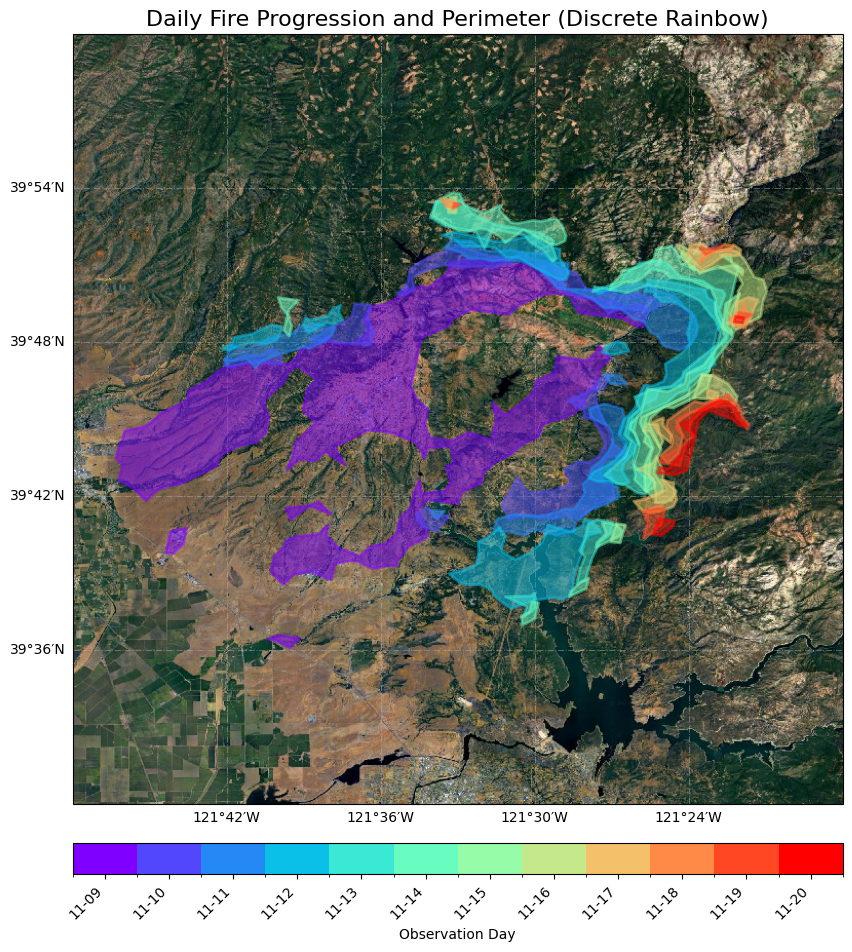

In [11]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """

    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull, []

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])


    lons, lats = points[:, 0], points[:, 1]
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    # Combine into projected coordinates (x, y)
    coords = np.vstack((xs, ys)).T  # shape: (N, 2)

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    # for ia, ib, ic in tri.vertices:
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))

        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))

    transformer_to_latlon = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

    # Transform each polygon
    concave_hull_latlon = transform(transformer_to_latlon.transform, unary_union(triangles))

    # Transform each edge segment back to lat/lon
    edge_points_latlon = []
    for line in edge_points:
        xs, ys = line[:, 0], line[:, 1]
        lons, lats = transformer_to_latlon.transform(xs, ys)
        edge_points_latlon.append(np.vstack((lons, lats)).T)  # shape: (2, 2)


    return concave_hull_latlon, edge_points_latlon

import math
from pyproj import Transformer
from shapely.ops import transform

from scipy.spatial import Delaunay
import shapely.geometry as geometry
from shapely.ops import polygonize, unary_union
from shapely.geometry import Point, Polygon, GeometryCollection, mapping, MultiPolygon

# 1. Group all points by day for perimeters
points_by_day = []
for i, day in enumerate(days_unique):
    mask = (day_labels == day)
    lons_day = all_lons[mask]
    lats_day = all_lats[mask]
    if len(lons_day) > 2:  # Need at least 3 for a polygon
        pts = np.column_stack([lons_day, lats_day])
        points_by_day.append(pts)
    else:
        points_by_day.append(None)

# 2. Plot
fig, axes, proj = multiFigure(1, 1, figsize=(10, 10), proj=ccrs.PlateCarree())
ax = axes[0]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linestyle='-.', linewidth=0.7, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Plot satellite basemap (optional, see earlier code)
# import cartopy.io.img_tiles as cimgt
# tiler = cimgt.GoogleTiles(style='satellite')
# ax.add_image(tiler, zoom=12)

# Use the same discrete rainbow colormap for consistency
from matplotlib import colors as mcolors
Ndays = len(days_unique)
base_cmap = plt.get_cmap('rainbow')
colors = base_cmap(np.linspace(0, 1, Ndays))
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(Ndays + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Add a high-resolution Google satellite imagery background for geographic context
tiler = cimgt.GoogleTiles(style='satellite')  # May require API key in some environments
zoom = 12  # Increase zoom for smaller areas, decrease for wider regions
ax.add_image(tiler, zoom)

# For each day, compute and plot perimeter
for i, pts in enumerate(points_by_day):
    if pts is None or len(pts) < 4:
        continue
    try:
        hull, _ = alpha_shape(pts, alpha=1/1000)  # Adjust alpha as needed for your fire shapes!

        # Plot the polygon (fire perimeter) with matching color and some transparency
        if hull.geom_type == 'Polygon':
            ax.add_geometries([hull], ccrs.PlateCarree(),
                             facecolor=colors[i], edgecolor=colors[i],
                             alpha=0.5, linewidth=2, zorder=20+i, label=days_unique[i])
        elif hull.geom_type == 'MultiPolygon':
            for geom in hull.geoms:
                ax.add_geometries([geom], ccrs.PlateCarree(),
                                 facecolor=colors[i], edgecolor=colors[i],
                                 alpha=0.5, linewidth=2, zorder=20+i, label=days_unique[i])
    except Exception as e:
        print(f"Failed to create alpha shape for {days_unique[i]}: {e}")

# Create a dummy mappable for the colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])  # Needed for older matplotlib, safe to include
# Colorbar will use the colormap (which is still opaque)
cax = add_horizontal_cbar(fig, ax, ratio=0.04, y_off=-0.07)
cb = plt.colorbar(mappable, cax=cax, orientation='horizontal', label='Observation Day',
                  ticks=np.arange(Ndays), boundaries=bounds)
cb.set_ticklabels(days_unique)
cb.ax.set_xticklabels(days_unique, rotation=45, ha='right')

ax.set_title("Daily Fire Progression and Perimeter (Discrete Rainbow)", fontsize=16)

plt.show()
